In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os
import urllib.request
import random
import string
# --- VISUALIZZAZIONE DI VERIFICA (Matplotlib) ---
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- CONFIGURAZIONE ---
IMG_H, IMG_W = 128, 128
PATCH_SIZE = 8  # La dimensione della tua cella (e del carattere)
FONT_URL = "http://viznut.fi/unscii/unscii-8.ttf"
FONT_FILENAME = "unscii-8.ttf"

def download_font():
    if not os.path.exists(FONT_FILENAME):
        print(f"Scaricamento font {FONT_FILENAME} per pixel-perfect rendering...")
        try:
            urllib.request.urlretrieve(FONT_URL, FONT_FILENAME)
            print("Download completato.")
        except Exception as e:
            print(f"Errore download: {e}. Assicurati di avere 'unscii-8.ttf' nella cartella.")

class GridOCRDataset(Dataset):
    def __init__(self, num_samples, img_h=128, img_w=128, patch_size=8):
        self.num_samples = num_samples
        self.img_h = img_h
        self.img_w = img_w
        self.patch_size = patch_size
        
        # Dimensioni della griglia (es. 128/8 = 16 righe/colonne)
        self.grid_rows = img_h // patch_size
        self.grid_cols = img_w // patch_size
        self.total_patches = self.grid_rows * self.grid_cols
        
        # Vocabolario esteso (ASCII + Esempio UTF Latin-1)
        # Nota: Unscii supporta molto altro, qui metto un subset per demo
        self.chars = [' '] + list(string.ascii_letters + string.digits + string.punctuation + "ÀÈÉÌÒÙàèéìòùÇçÑñ")
        self.char_to_idx = {c: i for i, c in enumerate(self.chars)}
        self.idx_to_char = {i: c for i, c in enumerate(self.chars)}
        self.vocab_size = len(self.chars)

        # Caricamento Font
        # size=8 con questo font garantisce 1 pixel font = 1 pixel immagine
        try:
            self.font = ImageFont.truetype(FONT_FILENAME, size=patch_size)
        except OSError:
            print("Font non trovato, uso default (l'allineamento potrebbe rompersi!)")
            self.font = ImageFont.load_default()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # 1. Canvas nero
        image = Image.new('L', (self.img_w, self.img_h), color=0)
        draw = ImageDraw.Draw(image)
        
        # 2. Target tensor (inizializzato a 0 = SPAZIO)
        target = torch.zeros((self.total_patches,), dtype=torch.long)
        
        patch_idx = 0
        """ for r in range(self.grid_rows):
            for c in range(self.grid_cols):
                # Densità del testo: 50% di probabilità che la cella sia piena
                if random.random() > 0.5:
                    char = random.choice(self.chars[1:]) # Skip spazio
                    
                    # Coordinate esatte
                    x = c * self.patch_size
                    y = r * self.patch_size
                    
                    # Disegno
                    draw.text((x, y), char, fill=255, font=self.font)
                    
                    # Label
                    target[patch_idx] = self.char_to_idx[char]
                
                patch_idx += 1 """
        
        word = "Ciao come; è và?"
        draw.text((0, 0), word, fill=255, font=self.font)
        for char in word:
            target[patch_idx] = self.char_to_idx[char]
            patch_idx += 1

        
        # Normalizzazione [0, 1] e aggiunta canale
        img_tensor = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0) / 255.0
        
        return img_tensor, target

In [58]:
import textwrap


def ensure_font():
    if not os.path.exists(FONT_FILENAME):
        print("Scaricamento font Unscii-8...")
        urllib.request.urlretrieve(FONT_URL, FONT_FILENAME)

class DocumentRenderer:
    def __init__(self, img_h=128, img_w=128, patch_size=8):
        ensure_font()
        self.img_h = img_h
        self.img_w = img_w
        self.patch_size = patch_size
        
        # Calcolo dimensioni griglia (es. 16x16 caratteri)
        self.rows = img_h // patch_size
        self.cols = img_w // patch_size
        self.patches_per_page = self.rows * self.cols
        
        # Caricamento Font
        self.font = ImageFont.truetype(FONT_FILENAME, size=patch_size)
        
        # Vocabolario (0 riservato per SPAZIO/Padding)
        # Aggiungiamo caratteri comuni per documenti
        self.chars = [' '] + list(string.ascii_letters + string.digits + string.punctuation + "\n")
        self.char_to_idx = {c: i for i, c in enumerate(self.chars)}
        self.idx_to_char = {i: c for i, c in enumerate(self.chars)}
        self.vocab_size = len(self.chars)

    def text_to_pages(self, long_text):
        """
        Input: Stringa lunga.
        Output: Tensor Immagini, Tensor Labels
        Logica: Character-level wrapping (spezza le parole).
        """
        # 1. Pulizia base
        text = long_text.replace('\t', '  ') # Tab -> 2 spazi
        # Sostituisci caratteri non supportati con '?'
        text = ''.join([c if c in self.char_to_idx else '?' for c in text])
        
        # 2. Creazione delle linee "Visive" (Slicing brutale)
        # Prima dividiamo per i \n originali per rispettare i paragrafi
        original_paragraphs = text.split('\n')
        visual_lines = []
        
        for p in original_paragraphs:
            if len(p) == 0:
                # Se c'era un a capo vuoto, aggiungiamo una riga vuota
                visual_lines.append(" " * self.cols)
                continue
            
            # --- IL CUORE DEL CAMBIAMENTO ---
            # Affettiamo la stringa ogni 'self.cols' caratteri
            # Esempio: "CIAOCOMESTAI" (cols=4) -> "CIAO", "COME", "STAI"
            chunks = [p[i : i + self.cols] for i in range(0, len(p), self.cols)]
            visual_lines.extend(chunks)

        # 3. Paginazione (Raggruppiamo le linee in pagine)
        # Dividiamo la lista visual_lines in gruppi di 'self.rows'
        pages_of_lines = [visual_lines[i : i + self.rows] for i in range(0, len(visual_lines), self.rows)]
        
        n_pages = len(pages_of_lines)
        images_tensor = torch.zeros((n_pages, 1, self.img_h, self.img_w), dtype=torch.float32)
        labels_tensor = torch.zeros((n_pages, self.patches_per_page), dtype=torch.long)
        
        # 4. Rendering
        for p_idx, lines in enumerate(pages_of_lines):
            img = Image.new('L', (self.img_w, self.img_h), color=0)
            draw = ImageDraw.Draw(img)
            
            for r, line in enumerate(lines):
                # Padding manuale con spazi se la riga è l'ultima del paragrafo e non riempie la larghezza
                line = line.ljust(self.cols)
                
                for c, char in enumerate(line):
                    # Disegno Pixel
                    x, y = c * self.patch_size, r * self.patch_size
                    if char != ' ':
                        draw.text((x, y), char, fill=255, font=self.font)
                    
                    # Label
                    flat_idx = r * self.cols + c
                    if char in self.char_to_idx:
                        labels_tensor[p_idx, flat_idx] = self.char_to_idx[char]
            
            images_tensor[p_idx, 0] = torch.from_numpy(np.array(img)) / 255.0
            
        return images_tensor, labels_tensor
# --- UTILIZZO E VISUALIZZAZIONE ---

# 1. Testo di esempio (DocString di Python o Lorem Ipsum)
sample_document = """
VISION TRANSFORMER PROJECT
--------------------------
Obiettivo: OCR su griglia.
Font: Unscii-8 (Monospace).

Questo testo e' generato automaticamente per testare la capacita' del sistema di gestire il wrapping.
Se scrivo una frase molto lunga, questa dovrebbe andare a capo automaticamente senza spezzare le parole a meta', grazie alla libreria textwrap di Python.

Formula: E = mc^2
Codice:
def hello():
    print("World")

Fine del documento.
"""

# 2. Inizializza Renderer
renderer = DocumentRenderer(img_h=256, img_w=256, patch_size=8)
print(f"Griglia: {renderer.rows} righe x {renderer.cols} colonne per pagina.")

# 3. Genera Immagini
images, labels = renderer.text_to_pages(sample_document)

images[0]

Griglia: 32 righe x 32 colonne per pagina.


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [59]:
len(labels[0])

1024

In [60]:
len(sample_document)

447

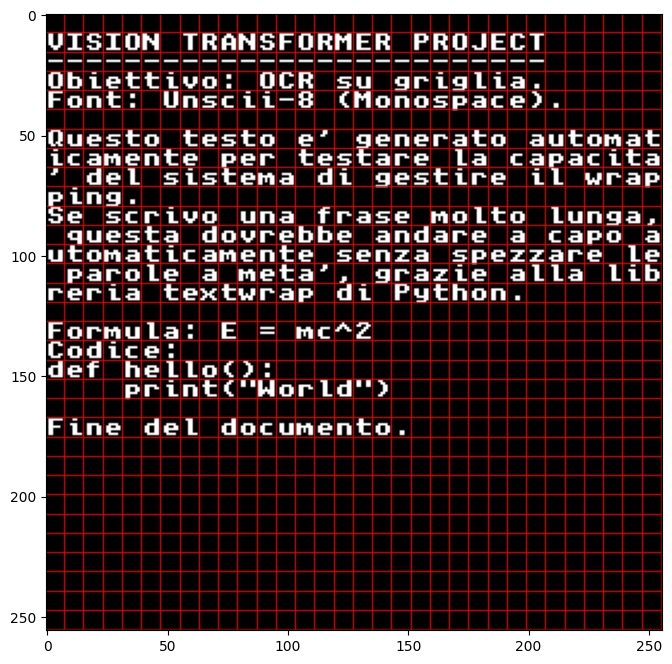

In [61]:
download_font()

# Convertiamo per visualizzare
img_np = images[0].squeeze().numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img_np, cmap='gray')

# Disegniamo la griglia rossa sopra per vedere se combacia con i caratteri
# Se il carattere è perfettamente dentro il quadrato rosso, il ViT funzionerà.
for r in range(renderer.rows):
    for c in range(renderer.cols):
        rect = patches.Rectangle(
            (c * PATCH_SIZE - 1, r * PATCH_SIZE - 1), # -0.5 per centrare visivamente sulle linee pixel
            PATCH_SIZE, PATCH_SIZE, 
            linewidth=1, edgecolor='r', facecolor='none', alpha=0.5
        )
        ax.add_patch(rect)
        
plt.show()